# 2.06 - Defining an Objective Function
This workbook takes us through the formulation of an objective function to help indicate the 'goodness' of a night, in terms of glycaemic control, where the night is defined as the period between 22:00 and 06:00 the following day. To recap, the following measures have been studied and will contribute as components to the objective function. These are recorded at each 30 minutes interval in our dataset:
- Blood Glucose Mean
- Blood Glucose Standard Deviation
- Coefficient of Variation
- Intervals Outside Level 1 Target Range
- Intervals Outside Level 2 Target Range
- Amplitude of Glycaemic Variability (absolute value above 1 SD from the mean)
- Peaks of Carbohydrate Intake

The goal is still to produce a continuous variable where the score indicates the quality of the night, encompassing the physiological impact observed through glycaemic metrics and carbohydrate intake, with a higher score indicating greater disturbance.

## Method - Overview of Objective Function Components

For each night (22:00 to 06:00), the 30-minutes intervals are aggregated data for the following metrics:
- Blood Glucose Mean ($BG_Mean_Night$): The average of all 30-minute BG means throughout the night. A higher average BG suggests potential discomfort or dysregulation.
- Blood Glucose Standard Deviation ($BG\_SD\_Night$): The average of all 30-minute BG standard deviations (or the overall standard deviation of all BG readings during the night). High variability can indicate instability and potential physiological stress.
- NOTE: The Law of Total Variance for Aggregated Data (for which we have at the 30 minute intervals, from the original irregular time series provides a more statistically robust measure of variability than the simple average of standard deviations):
  - $\text{Var}(X) = E[\text{Var}(X|Y)] + \text{Var}(E[X|Y])$
  - This means that the variance of the aggregated data is the sum of the expected variance within each group and the variance of the group means. The theoretical formula for the overall standard deviation of the aggregated data is as follows:
Let $X$ be the original, high-frequency blood glucose readings.
Let $Y$ represent the 30-minute time intervals (or groups).
Let $g_i$ be the blood glucose mean for interval $i$.
Let $s_i$ be the blood glucose for interval $i$.
Let $s_i^2$ be the variance within interval $i$ (which is $s_i$ squared).
Let $n_i$ be the number of original readings that were aggregated into interval $i$.
Leading to the formula for variance:

$\text{Var}_{overall} = \frac{\sum_{i=1}^K n_i \cdot s_i^2}{\sum_{i=1}^K n_i} + \frac{\sum_{i=1}^K n_i \cdot (g_i-\bar G)^2}{\sum_{i=1}^K n_i}$

And standard deviation:
$\sigma_{overall} = \sqrt{\text{Var}_{overall}}$

Where:
- $K$ is the total number of 30-minute intervals in the night.
- $\bar G$ is the overall mean of all blood glucose readings during the night.

- Coefficient of Variation ($CV\_Night$): The average of the 30-minute Coefficient of Variation values. This normalizes variability to the mean, providing a robust measure of relative glucose fluctuations, which can be disturbing.
- Intervals Outside Level 1 Target Range ($L1_{Excursions\_Night}$): The sum or count of 30-minute intervals where a Level 1 (clinically defined) excursion occurred. These indicate deviations from a generally acceptable range, potentially causing discomfort or impacting restorative processes.
- Intervals Outside Level 2 Target Range ($L2_{Excursions\_Night}$): The sum or count of 30-minute intervals where a Level 2 (more severe) excursion occurred. These represent more significant deviations, very likely disruptive.
- Mean Amplitude of Glycaemic Variability ($MAGE$): The sum or average of the absolute amplitude values (above 1 SD from the mean). These capture significant, rapid swings in glucose, which are often associated with physiological stress or symptoms that could disturb sleep, even if within clinical thresholds. If the dataset is very sparse for this, consider summing non-zero amplitudes or taking the maximum amplitude for the night to highlight the presence of any large swings.
- Peaks of Carbohydrate Intake ($COB\_Peaks$): The count of peaks of COB for the night.

## Objective Function Definition
Let the following notation be used:
- $G_t$:Blood glucose reading at time t.
- $T$: Total number of time intervals in the observed period.
- $N$: The set of all glucose readings during the nocturnal period, $\{G_1, G_2, ..., G_T\}$.
- $G_{L1\_lower}$: Lower threshold for Level 1 excursion.
- $G_{L1\_upper}$: Upper threshold for Level 1 excursion.
- $G_{L2\_lower}$: Lower threshold for Level 2 excursion.
- $G_{L2\_upper}$: Upper threshold for Level 2 excursion.

All features are scaled using `StandardScaler` to ensure they contribute equally to the objective function. The scaling is done using the mean and standard deviation of each feature across all nights:

$X_{scaled} = \frac{X - \mu_X}{\sigma_X}$

Where $X$ is the original feature value, $\mu_X$ is the mean of the feature across all nights, and $\sigma_X$ is the standard deviation of the feature across all nights.

1. Minimising Variance Using Standard Deviation

$\mu_G = \frac{1}{T} \sum_{t=1}^{T} G_t$ is the mean of the glucose readings during the nocturnal period, thus the standard deviation is calculated as $\sigma_G = \sqrt{\frac{1}{T} \sum_{t=1}^{T} (G_t - \mu_G)^2}$.

3. Minimising Glycaemic Variability Using Coefficient of Variation

Standard deviation is a measure of variability, but it does not account for the mean level of glucose. The Coefficient of Variation (CV) is defined as $CV = \frac{\sigma_G}{\mu_G}$, which normalises the standard deviation by the mean glucose level, providing a relative measure of variability.

4. Minimising Excursions Outside Target Ranges

The ranges used here provide a clinically relevant context for evaluating glucose levels. The Level 1 excursion is defined as $G_{L1\_lower} \leq G_t \leq G_{L1\_upper}$, and the Level 2 excursion is defined as $G_{L2\_lower} \leq G_t \leq G_{L2\_upper}$. The number of intervals outside these ranges can be counted as follows:
- $L1\_Excursions = \sum_{t=1}^{T} \mathbb{1}_{G_t < G_{L1\_lower} \lor G_t > G_{L1\_upper}}$
- $L2\_Excursions = \sum_{t=1}^{T} \mathbb{1}_{G_t < G_{L2\_lower} \lor G_t > G_{L2\_upper}}$

5. Minimising Amplitude of Glycaemic Variability

....

6. Minimising Peaks of Carbohydrate Intake

Carbohydrate intake is a significant factor in glucose regulation. Peaks of carbohydrate intake can be counted as the number of times the carbohydrate intake exceeds a certain threshold during the nocturnal period. This can be defined as:
- $COB\_Peaks = \sum_{t=1}^{T} \mathbb{1}_{COB_t > COB\_threshold}$, where $COB_t$ is the carbohydrate intake at time t.
No carbohydrate height parameter is set as any peak is considered an indicator that the person is awake and eating, which is not ideal for a good night.

The objective function $J$ can be defined as a weighted sum of these components, $f$ be a features used in the objective function from the set $\{f_1, f_2, \dots , f_k\}$ and $w_k$ be a weight applied to the feature:

$J = \frac{\sum_{k=1}^K w_k \cdot f_k}{K}$


In [38]:
%load_ext autoreload
%autoreload 2

from datetime import time
import pandas as pd
import seaborn as sns
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.preprocessing import StandardScaler
from dtw import dtw
import numpy as np
import pickle
import matplotlib.dates as mdates

from src.dba import DBAAverager, get_dba_and_variance
from src.config import PROCESSED_DATA_DIR, FIGURES_DIR
from src.features import FeatureSet
from src.objective_function import ObjectiveFunction
from src.helper import normalise_overnight_time, cluster_colours, \
    generate_alphabetical_aliases

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
with open(PROCESSED_DATA_DIR / 'cust_analyser.pkl', 'rb') as file:
    analyser = pickle.load(file)

df_all = analyser.return_dataset_with_clusters()
df_all = df_all.rename(columns={'cluster_label': 'cluster'})
df_all['time'] = df_all.index.get_level_values('datetime').time
alias_ids = generate_alphabetical_aliases(df_all.reset_index()['id'])
df_all = df_all.reset_index()
df_all['id'] = df_all['id'].map(alias_ids)
df_all = df_all.set_index(['id','datetime'])
clusters = df_all.groupby(['id', 'night_start_date'])['cluster'].max()



sample_rate = 30

night_start = time(22, 0)
morning_end = time(6, 0)

def get_time_period(df, start_time, end_time):
    """Filter DataFrame for rows within the specified time period."""
    if end_time <= start_time:
        return df[(df['time'] >= start_time) | (df['time'] < end_time)]
    else:
        return df[(df['time'] >= start_time) & (df['time'] < end_time)]

df_overnight = get_time_period(df_all, night_start, morning_end)

In [40]:
# Get features for the overnight period
features = FeatureSet(df_overnight, sample_rate=sample_rate)
df_features = features.get_all_features(scale=False)
features_scaled = FeatureSet(df_overnight, sample_rate=sample_rate)
df_scaled = features_scaled.get_all_features(scale=True)
# df_scaled = df_scaled.reset_index()
# df_scaled['id'] = df_scaled['id'].map(alias_ids)
# df_scaled = df_scaled.set_index(['id', 'datetime'])

Scaling ['iob mean', 'cob mean', 'bg mean', 'bg min', 'iob max', 'cob max', 'bg max', 'bg std', 'bg count', 'day_type_weekday', 'day_type_weekend', 'iob mean_rate_of_change', 'cob mean_rate_of_change', 'bg mean_rate_of_change', 'iob mean hourly_mean', 'cob mean hourly_mean', 'bg mean hourly_mean', 'bg max_peaks_above_mean', 'iob max_peaks_above_mean', 'cob max_peaks_above_mean', 'hour_of_day', 'hour_sin', 'hour_cos', 'l1_hypo', 'l1_hyper', 'l2_hypo', 'l2_hyper', 'excursion_amplitude', 'excursion_flag', 'cob_peaks'] columns


Now we have the set of features at a time interval level, we need to aggregate them at a night level, which is

In [41]:
weights = [1, 1, 1, 1, 1.5, 1.5]
obj_func = ObjectiveFunction(df_overnight, weights=weights, sample_rate=sample_rate)

Feature columns and order created, now apply weights using assign_weights:
Weights being set as follows:
bg_night_mean: 1
bg_night_std: 1
bg_night_cv: 1
l1_excursions: 1
l2_excursions: 1.5
mage: 1.5


In [42]:
scores = obj_func.get_objective_function_scores()

In [43]:
pd.set_option('display.float_format', '{:.5f}'.format)
scores.describe()

,score
count,922.00000
mean,0.00000
std,0.77875
min,-1.23223
25%,-0.57659
50%,-0.16166
75%,0.34590
max,3.01830


In [44]:
print('Skewness: ', stats.skew(scores))
print('Kurtosis: ', stats.kurtosis(scores))

Skewness:  [1.32789204]
Kurtosis:  [1.86150475]


In [45]:
evening_start = time(17, 0)
evening_end = time(22, 30)
df_evening = get_time_period(df_all, evening_start, evening_end)

def background_mean(mean_col, count_col):
    """Calculate the background mean for a feature."""
    return (mean_col * count_col).sum() / count_col.sum()

evenings_agg = []
for (id_, night_start_date), night_df in df_evening.groupby(['id', 'night_start_date']):
    agg_dict = {
        'id': id_,
        'night_start_date': night_start_date,
        'evening_COB_mean': background_mean(night_df['cob mean'], night_df['cob count']),
        'evening_IOB_mean': background_mean(night_df['iob mean'], night_df['iob count']),
    }
    evenings_agg.append(agg_dict)
evening_means = pd.DataFrame(evenings_agg).set_index(['id', 'night_start_date'])
evening_means = evening_means.join(scores)
evening_means = evening_means.join(clusters)

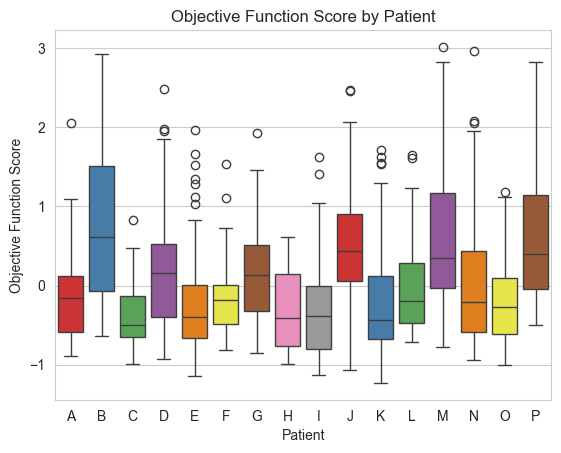

In [46]:
sns.boxplot(
    data=evening_means,
    x='id',
    y='score',
    hue='id',
    palette='Set1',
    legend=False)

plt.xlabel('Patient')
plt.ylabel('Objective Function Score')
plt.title('Objective Function Score by Patient')
plt.savefig(FIGURES_DIR / 'obj_function_scores_by_patient.png', bbox_inches='tight')
plt.show()

In [47]:
scores.groupby('id').mean().describe()

,score
count,16.00000
mean,0.07285
std,0.39448
min,-0.36722
25%,-0.22469
50%,-0.04967
75%,0.29650
max,0.86537


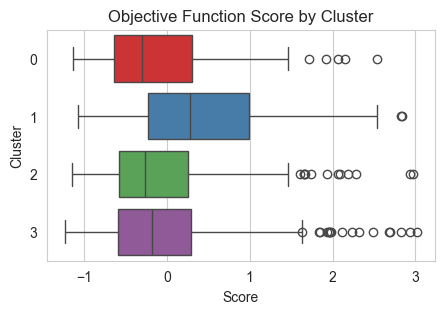

In [48]:
fig = plt.figure(figsize=(5, 3))
sns.boxplot(
    data=evening_means,
    x='score',
    y='cluster',
    hue='cluster',
    palette='Set1',
    orient='h',
    legend=False)

plt.xlabel('Score')
plt.ylabel('Cluster')
plt.title('Objective Function Score by Cluster')
plt.savefig(FIGURES_DIR / 'obj_function_scores_by_cluster.png', bbox_inches='tight')
plt.show()

In [49]:
cluster_test = evening_means[['cluster', 'score']].copy()
cluster_labels = cluster_test['cluster'].unique()
cluster_scores = [cluster_test[cluster_test['cluster'] == c]['score'] for c in cluster_labels]

cluster_1_data = cluster_scores[1]
other_clusters_data = cluster_scores[:1] + cluster_scores[2:]
all_clusters_data = cluster_scores

kruskal_statistic, kruskal_p_value = stats.kruskal(*all_clusters_data)
print(f"Kruskal-Wallis H-statistic: {kruskal_statistic:.2f}")
print(f"P-value: {kruskal_p_value:.3f}")

if kruskal_p_value < 0.05:
    print("There is a significant difference in medians between the clusters.")
else:
    print("There is no significant difference in medians between the clusters.")

dunn_p_values = sp.posthoc_dunn(cluster_test, val_col='score', group_col='cluster', p_adjust='bonferroni')

print("\n--- Dunn's Post-Hoc Test Results ---")
print(dunn_p_values)

Kruskal-Wallis H-statistic: 30.55
P-value: 0.000
There is a significant difference in medians between the clusters.

--- Dunn's Post-Hoc Test Results ---
        0       1       2       3
0 1.00000 0.00001 1.00000 1.00000
1 0.00001 1.00000 0.00000 0.00001
2 1.00000 0.00000 1.00000 1.00000
3 1.00000 0.00001 1.00000 1.00000


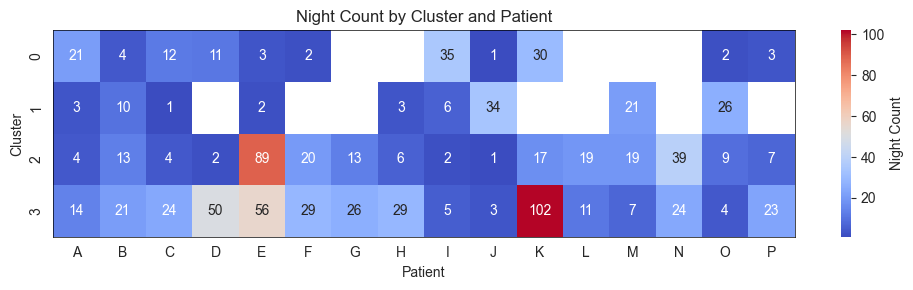

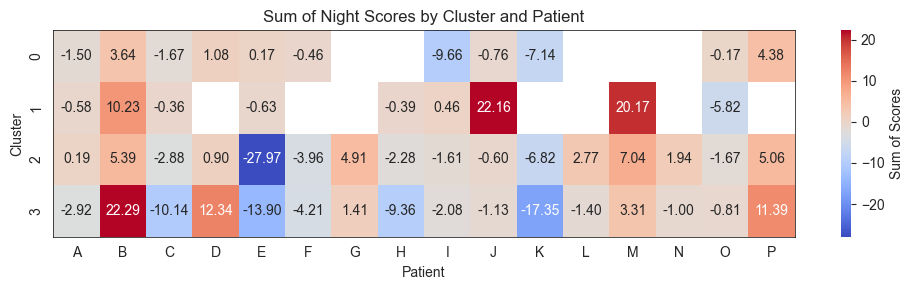

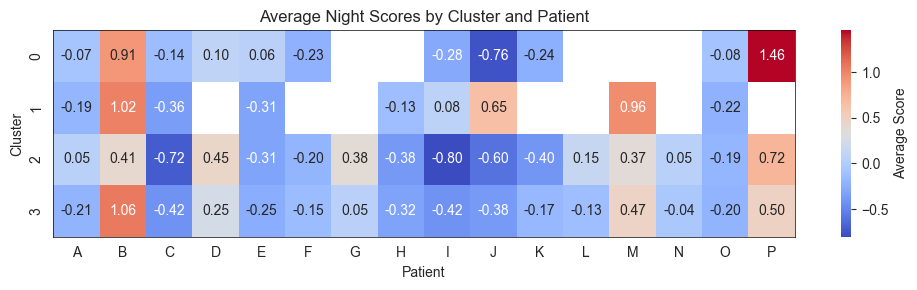

In [50]:
night_count = evening_means.groupby(['cluster', 'id'])['score'].count().unstack()
score_matrix_sum = evening_means.groupby(['cluster', 'id'])['score'].sum().unstack()
score_matrix_mean = evening_means.groupby(['cluster', 'id'])['score'].mean().unstack()

def cluster_patient_heatmap(df, title, cbar_title):

    def is_integer_like(x):
        if pd.isna(x):
            return True  # Ignore NaNs for this check
        return np.isclose(x % 1, 0)
    all_int = df.apply(lambda col: col.map(is_integer_like)).all().all()

    fig, ax = plt.subplots(figsize=(10, 3))

    fmt = '.0f' if all_int else '.2f'
    sns.heatmap(df, annot=True, fmt=fmt, cmap='coolwarm', cbar_kws={'label': cbar_title},)
    plt.xlabel('Patient')
    plt.ylabel('Cluster')
    plt.title(title)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)  # Adjust thickness as needed
        spine.set_color('black')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f'{title.replace(" ", "_").lower()}.png', bbox_inches='tight')
    plt.show()

cluster_patient_heatmap(night_count, 'Night Count by Cluster and Patient', 'Night Count')
cluster_patient_heatmap(score_matrix_sum, 'Sum of Night Scores by Cluster and Patient', 'Sum of Scores')
cluster_patient_heatmap(score_matrix_mean, 'Average Night Scores by Cluster and Patient', 'Average Score')

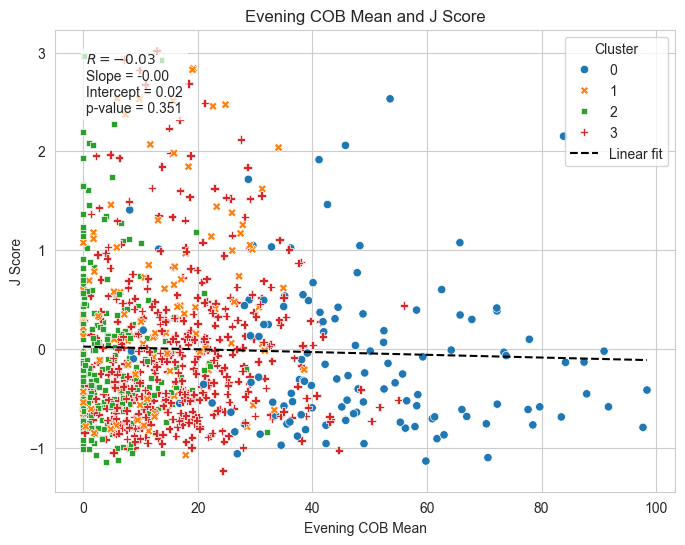

Correlation coefficient (r) between evening_COB_mean and score: -0.0308


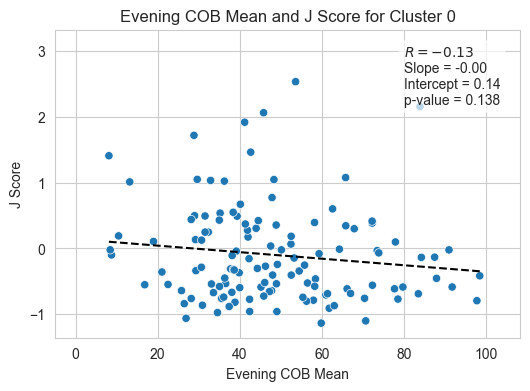

Correlation coefficient (r) between evening_COB_mean and score: -0.1340


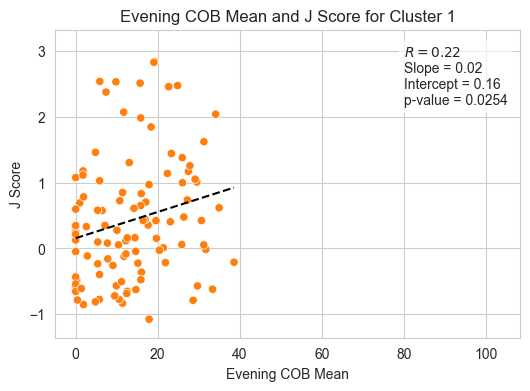

Correlation coefficient (r) between evening_COB_mean and score: 0.2170


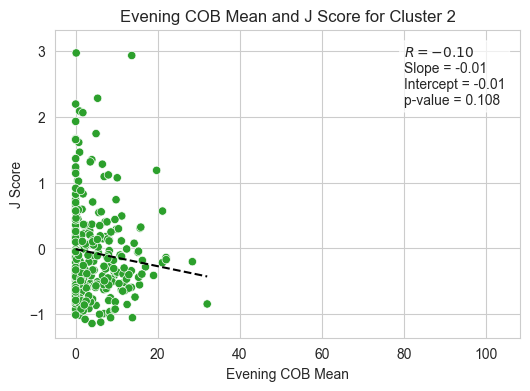

Correlation coefficient (r) between evening_COB_mean and score: -0.0991


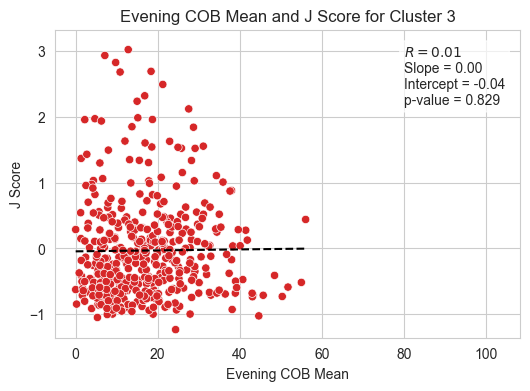

Correlation coefficient (r) between evening_COB_mean and score: 0.0105


In [51]:
def plot_scores_scatter(df, x_var, title, xlim=None, ylim=None, cluster=None):
    colours = cluster_colours()
    figsize = (8,6) if cluster is None else (6,4)
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.scatterplot(
        df,
        x=x_var,
        y='score',
        hue='cluster',
        palette=colours,
        style='cluster'
    )

    X = df[x_var].values.reshape(-1, 1)
    y = df['score'].values

    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
    textstr = f'$R = {r_value:.2f}$\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}\np-value = {p_value:.3g}'
    x_vals = np.linspace(X.min(), X.max(), 100)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color='black', linestyle='--', label='Linear fit')
    if cluster is None:
        ax.legend(title='Cluster', loc='upper right')
        xy = (0.05, 0.95)
    else:
        ax.get_legend().remove()
        xy = (0.75, 0.95)

    ax.annotate(textstr, xy=xy, xycoords='axes fraction', fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    ax.set_xlabel(" ".join(word[0].upper() + word[1:] for word in x_var.replace('_', ' ').split()))
    ax.set_ylabel('J Score')
    if xlim is not None:
        ax.set_xlim(xlim)
    if y is not None:
        ax.set_ylim(ylim)
    plt.title(title)
    plt.savefig(FIGURES_DIR / f'objective_function_{x_var}_{cluster if cluster is not None else "all"}.png', bbox_inches='tight')
    plt.show()
    print(f'Correlation coefficient (r) between {x_var} and score: {r_value:.4f}')
    return {'slope': slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value}

variable = 'evening_COB_mean'

plot_scores_scatter(evening_means, variable, 'Evening COB Mean and J Score')
xlim = (-5, evening_means[variable].max()*1.1)
ylim = (evening_means['score'].min()*1.1, evening_means['score'].max()*1.1)
linreg = dict()
for c, df in evening_means.groupby('cluster'):
    title = f'Evening COB Mean and J Score for Cluster {c}'
    linreg[c] = plot_scores_scatter(df, variable, title, xlim, ylim, c)
cob_reg_results = pd.DataFrame(linreg).T

Reviewing a scatter plot of night COB background weighted means against objective function score, we can see some distinction between similarity of cluster points as would be expected. There is a slight negative correlation with an r-score of -0.03, and conclude there is no linear relationship to note. IOB background weighted show a slight correlation with an r coefficient of 0.24 and a p-value of < 0.05. This indicates be some positive linearity but certainly not prominent and with a significant level of noise.

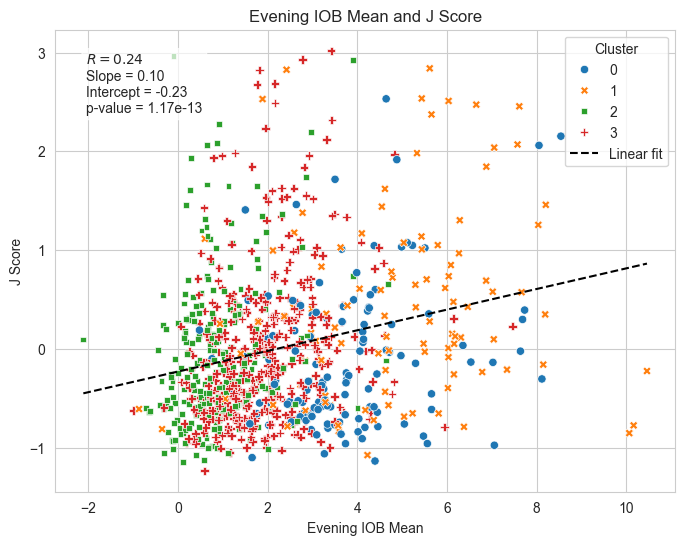

Correlation coefficient (r) between evening_IOB_mean and score: 0.2411


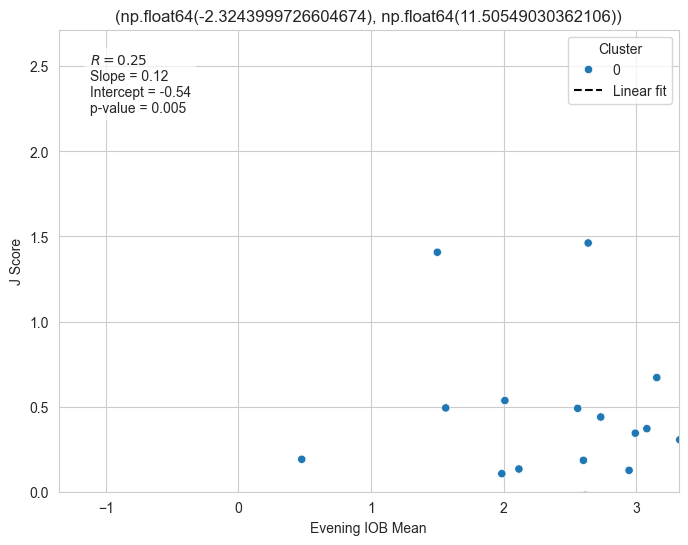

Correlation coefficient (r) between evening_IOB_mean and score: 0.2506


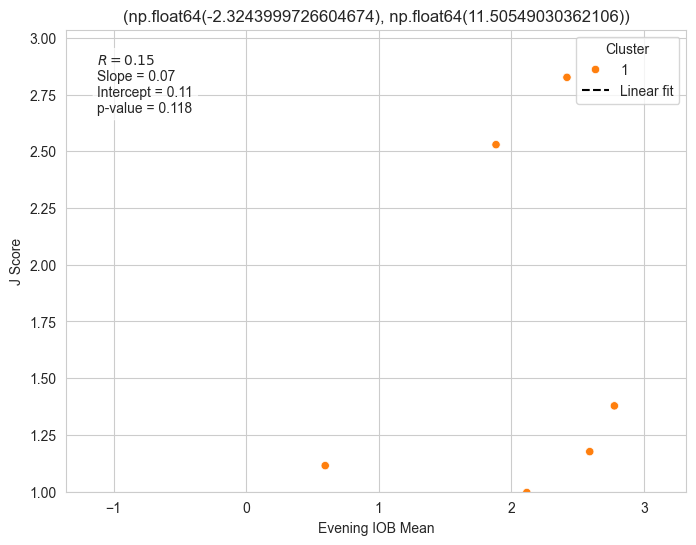

Correlation coefficient (r) between evening_IOB_mean and score: 0.1526


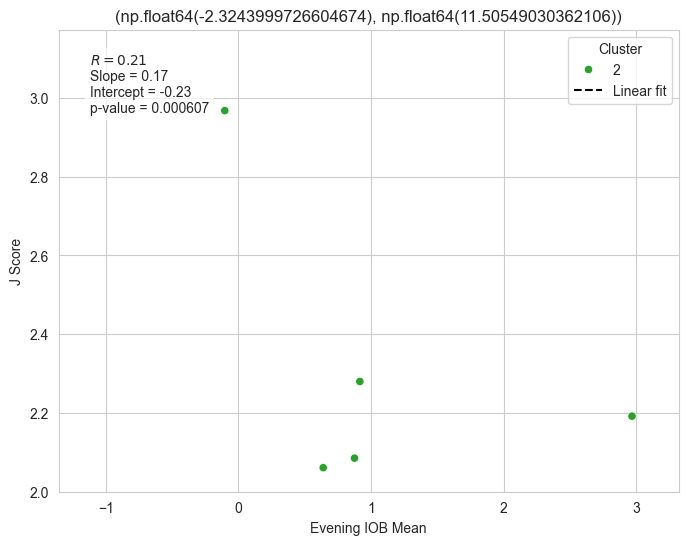

Correlation coefficient (r) between evening_IOB_mean and score: 0.2096


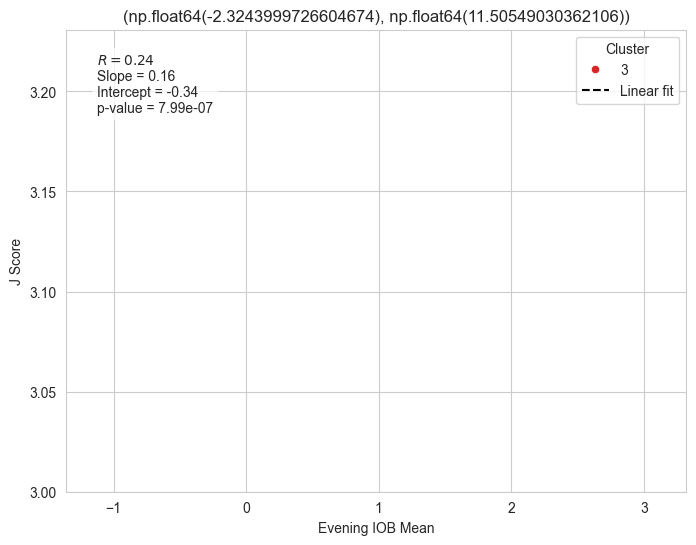

Correlation coefficient (r) between evening_IOB_mean and score: 0.2359


In [52]:
variable = 'evening_IOB_mean'

plot_scores_scatter(evening_means, variable, 'Evening IOB Mean and J Score')
xlim = (evening_means[variable].min()*1.1, evening_means[variable].max()*1.1)
ylim = (evening_means['score'].min()*1.1, evening_means['score'].max()*1.1)
linreg = dict()
for c, df in evening_means.groupby('cluster'):
    title = f'Evening IOB Mean and J Score for Cluster {c}'
    linreg[c] = plot_scores_scatter(df, variable, xlim, ylim, c)
iob_reg_results = pd.DataFrame(linreg).T

In [53]:
columns = {'slope': 'Slope', 'intercept': 'Intercept', 'r_value': 'R-value', 'p_value': 'P-value'}
wide_table = pd.concat(
    [cob_reg_results.rename(columns=columns), iob_reg_results.rename(columns=columns)],
    axis=1,
    keys=['Evening COB vs Score', 'Evening IOB vs Score']
)

print(wide_table.to_latex(float_format="%.2f",
    caption="Results of linear regression between evening means (between 17:00-22:30) of COB and IOB relative to the objective function score for each cluster.",
    label="tab:obj_func_linreg_scores",
    bold_rows=True,
    position="h!" ))

\begin{table}[h!]
\caption{Results of linear regression between evening means (between 17:00-22:30) of COB and IOB relative to the objective function score for each cluster.}
\label{tab:obj_func_linreg_scores}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{Evening COB vs Score} & \multicolumn{4}{r}{Evening IOB vs Score} \\
 & Slope & Intercept & R-value & P-value & Slope & Intercept & R-value & P-value \\
\midrule
\textbf{0} & -0.00 & 0.14 & -0.13 & 0.14 & 0.12 & -0.54 & 0.25 & 0.00 \\
\textbf{1} & 0.02 & 0.16 & 0.22 & 0.03 & 0.07 & 0.11 & 0.15 & 0.12 \\
\textbf{2} & -0.01 & -0.01 & -0.10 & 0.11 & 0.17 & -0.23 & 0.21 & 0.00 \\
\textbf{3} & 0.00 & -0.04 & 0.01 & 0.83 & 0.16 & -0.34 & 0.24 & 0.00 \\
\bottomrule
\end{tabular}
\end{table}



In [54]:
stats_df = evening_means.groupby(['id']).agg(
    mean_score=('score', 'mean'),
    std_score=('score', 'std'),
    min_score=('score', 'min'),
    max_score=('score', 'max'),
    count=('score', 'count')
)

In [55]:
print(f'Min mean score: {stats_df["mean_score"].min(): .3f}')
print(f'Max mean score: {stats_df["mean_score"].max(): .3f}')

Min mean score: -0.367
Max mean score:  0.865


Looking at the distribution of $J$ score by patient, we see some differences with means. The maximum $J$ and maximum difference between mean and max score exists for the same individual. we  to see if there is any notable distinction between this max-score night and an average-score night for an patient.

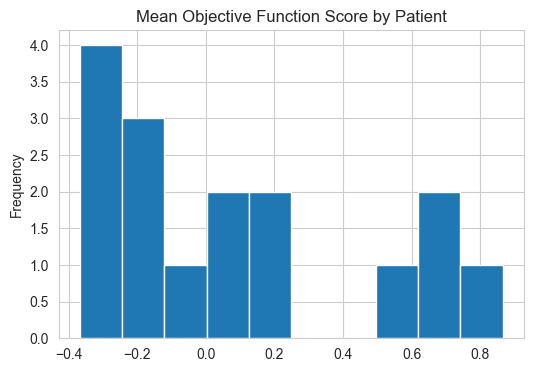

In [56]:
stats_df['mean_score'].sort_values(ascending=False).plot(
    kind='hist', bins=10,
    figsize=(6, 4),
    title='Mean Objective Function Score by Patient')
plt.show()

Despite the few numbers of patients, we see that the distribution of mean objective function scores to likely be not normally distribution, tending to be skewed left. This is consistent with the expectation that most nights are 'good' nights, with a few outliers being 'bad' nights. The next step is to look at the patient with the maximum difference between their mean and maximum score, to see if there is any notable pattern in their data.

In [57]:
score_max_diff = dict()
for id_, nights_df in evening_means.groupby('id'):
    max_score = nights_df['score'].max()
    mean_score = nights_df['score'].mean()
    max_score_night = nights_df.loc[nights_df['score'] == max_score].index.get_level_values('night_start_date')[0]
    temp_dict = {
        'max_score': max_score,
        'mean_score': mean_score,
        'max_diff': max_score - mean_score,
        'max_score_night': max_score_night
    }
    score_max_diff[id_] = temp_dict

In [58]:
# Find the id with the maximum difference
max_diff_id = max(score_max_diff, key=lambda k: score_max_diff[k]['max_diff'])
# Get the corresponding max_score_night
max_score_night = score_max_diff[max_diff_id]['max_score_night']
mean_score = score_max_diff[max_diff_id]['mean_score']
print('ID with max diff:', max_diff_id)
print('Night with max score:', max_score_night)
print(f'Mean score for patient: {mean_score:.2f}')
print(f'Max score for patient: {max_score:.2f}')

ID with max diff: N
Night with max score: 2017-08-26 00:00:00
Mean score for patient: 0.02
Max score for patient: 2.82


In [59]:
var_cols = ['cob mean','cob max', 'iob mean', 'iob max']
plot_cols = var_cols + ['night_start_date']

md_scaled = df_scaled.loc[[max_diff_id]][plot_cols].reset_index().copy()
md_scaled = md_scaled.melt(id_vars=['id', 'night_start_date', 'datetime'], value_vars=plot_cols, var_name='feature', value_name='value')
md_scaled['datetime'] = md_scaled['datetime'].apply(lambda x: normalise_overnight_time(x, morning_end.hour))
md_scaled.head()

,id,night_start_date,datetime,feature,value
0,N,2017-03-31,1900-01-01 22:00:00,cob mean,-0.27127
1,N,2017-03-31,1900-01-01 22:30:00,cob mean,-0.27127
2,N,2017-03-31,1900-01-01 23:00:00,cob mean,-0.27127
3,N,2017-03-31,1900-01-01 23:30:00,cob mean,-0.27127
4,N,2017-03-31,1900-01-02 00:00:00,cob mean,-0.27127


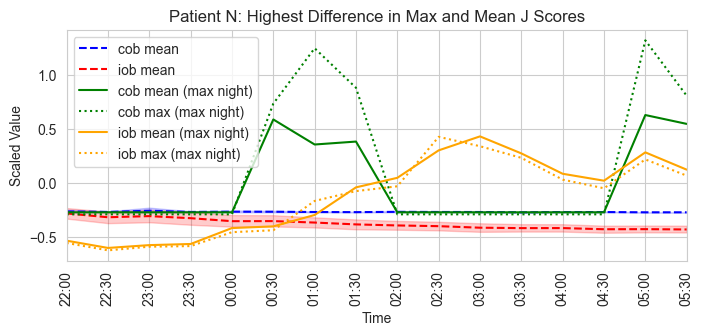

Number of nights for patient N: 63


In [60]:
custom_palette = {
    'cob mean': 'green',
    'cob max': 'green',
    'iob mean': 'orange',
    'iob max': 'orange',
}

custom_line_styles = {
    'cob mean': '-',
    'cob max': ':',
    'iob mean': '-',
    'iob max': ':',
}

max_night_df = md_scaled[md_scaled['night_start_date'] == max_score_night]
other_nights_df = md_scaled[(md_scaled['night_start_date'] != max_score_night) &
                            (~md_scaled['feature'].isin(['iob max', 'cob max']))]

fig, ax = plt.subplots(figsize=(8, 3))

sns.lineplot(other_nights_df[other_nights_df['night_start_date'] != max_score_night],
             x='datetime', y='value',
             hue='feature', linestyle='--', palette=['blue', 'red'], errorbar=('ci', 95),
             ax=ax)
for feature, style in custom_line_styles.items():
    sns.lineplot(max_night_df[max_night_df['feature']==feature], x='datetime', y='value', linestyle=custom_line_styles[feature],
                 markers=True, color=custom_palette[feature], ax=ax, label=f'{feature} (max night)')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.set_xlim(other_nights_df['datetime'].min(), other_nights_df['datetime'].max())
plt.xticks(rotation=90)
plt.ylabel('Scaled Value')
plt.xlabel('Time')
plt.title('Patient N: Highest Difference in Max and Mean J Scores')
plt.savefig(FIGURES_DIR / 'patient_n_max_diff_in_j_score.png', bbox_inches='tight')
plt.show()

patient_scores = evening_means.loc[[max_diff_id]].sort_values('score')
print(f'Number of nights for patient {max_diff_id}: {len(patient_scores)}')

For this patient, the average for all their nights but excluding the night with the maximum score, shows a very different pattern to the night with the maximum score. The average night is stable, has a stabe COB and stable (but slowly deprecating) IOB. The night with the maximum score shows a very different pattern, with a significant increase in carbohydrate intake and insulin on board, which is synonymous with what would be expected for a night with a high objective function score. However, this is the comparison of a single night which is interesting but not sufficient evidence of a pattern. Lets now look at the lower 50% of nights for this patient and compare to the upper 25% to see the differences.

In [61]:
def transform_time_series_df(df):
    df = df.melt(id_vars=['id', 'night_start_date', 'datetime'], value_vars=plot_cols, var_name='feature', value_name='value')
    df['datetime'] = df['datetime'].apply(lambda x: normalise_overnight_time(x, morning_end.hour))
    return df.set_index(['id', 'night_start_date'])

def split_patient_score_groups(patient_scores, time_series_df):
    nights = patient_scores.index
    n = len(nights)
    first_50_idx = nights[:n // 2]
    last_25_idx = nights[int(n * 0.75):]

    time_series_df = transform_time_series_df(time_series_df)

    first_50_df = time_series_df.loc[first_50_idx]
    last_25_df = time_series_df.loc[last_25_idx]

    print(f'Number of nights in first 50%: {len(first_50_idx)}')
    print(f'Number of nights in last 25%: {len(last_25_idx)}')

    return first_50_df, last_25_df

max_diff_df = df_scaled.loc[[max_diff_id]][plot_cols].reset_index().copy()
first_50_df, last_25_df = split_patient_score_groups(patient_scores, max_diff_df)

Number of nights in first 50%: 31
Number of nights in last 25%: 16


Patient N: Bottom 50% vs Top 25% J Score Nights


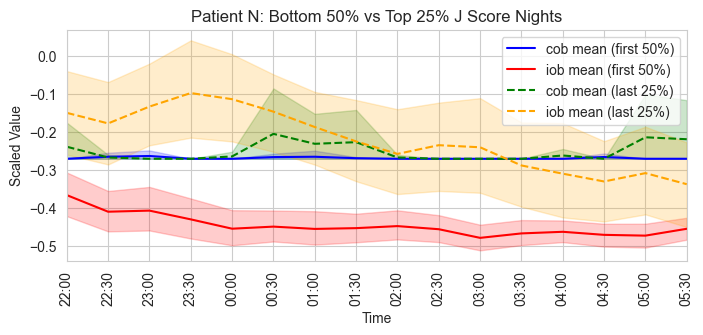

Number of nights for patient N: 63


In [62]:
def plot_top_and_bottom_scoring_nights(first_50_df, last_25_df, title, filename):
    print(title)
    first_50_palette = {
        'cob mean': 'blue',
        'iob mean': 'red'
    }
    last_25_palette = {
        'cob mean': 'green',
        'iob mean': 'orange'
    }

    fig, ax = plt.subplots(figsize=(8, 3))
    for feature, colour in first_50_palette.items():
        sns.lineplot(first_50_df[first_50_df['feature'] == feature], x='datetime',
                     y='value',
                     linestyle='-', color=colour,
                     errorbar=('ci', 95),
                     ax=ax, label=f'{feature} (first 50%)')
    for feature, colour in last_25_palette.items():
        sns.lineplot(last_25_df[last_25_df['feature'] == feature], x='datetime',
                     y='value',
                     linestyle='--', color=colour,
                        errorbar=('ci', 95),
                     ax=ax, label=f'{feature} (last 25%)')
    xmax = max(first_50_df['datetime'].max(), last_25_df['datetime'].max())
    xmin = min(first_50_df['datetime'].min(), last_25_df['datetime'].min())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    ax.set_xlim(xmin, xmax)
    plt.xticks(rotation=90)
    plt.xlabel('Time')
    plt.ylabel('Scaled Value')
    plt.title(title)
    plt.savefig(FIGURES_DIR / filename, bbox_inches='tight')
    plt.show()

title = 'Patient N: Bottom 50% vs Top 25% J Score Nights'
filename = 'comparison_bottom50_top25_max_diff_patient.png'
plot_top_and_bottom_scoring_nights(first_50_df, last_25_df, title, filename)
print(f'Number of nights for patient {max_diff_id}: {len(patient_scores)}')

In [63]:
def test_dtw_distance(time_series_df, first_50_df, last_25_df):

    def get_mean_series(df, feature, idx):
        sub = df[df['feature'] == feature].loc[idx].reset_index()
        pivot = sub.pivot(index=['id', 'night_start_date'], columns='datetime', values='value')
        return pivot.mean(axis=0).values  # Mean across nights for each timepoint

    first_50_idx = first_50_df.index.drop_duplicates()
    last_25_idx = last_25_df.index.drop_duplicates()

    melt_df = transform_time_series_df(time_series_df)

    mean_first_50_cob = get_mean_series(melt_df, 'cob mean', first_50_idx)
    mean_last_25_cob = get_mean_series(melt_df, 'cob mean', last_25_idx)
    mean_first_50_iob = get_mean_series(melt_df, 'iob mean', first_50_idx)
    mean_last_25_iob = get_mean_series(melt_df, 'iob mean', last_25_idx)

    dtw_cob = dtw(mean_first_50_cob, mean_last_25_cob, dist=lambda x, y: abs(x - y))
    dtw_iob = dtw(mean_first_50_iob, mean_last_25_iob, dist=lambda x, y: abs(x - y))

    print(f"DTW distance (cob mean): {dtw_cob[0]:.3f}")
    print(f"DTW distance (iob mean): {dtw_iob[0]:.3f}")

    # Test for statistical significance of differences in COB means between first 50% and last 25% nights
    def test_differences_in_means(df, feature, first_50_idx, last_25_idx):
        print(f'\nTesting differences in means for {feature}...')
        first_50_values = df[df['feature'] == feature].loc[first_50_idx]['value']
        last_25_values = df[df['feature'] == feature].loc[last_25_idx]['value']
        t_res = stats.ttest_ind(first_50_values, last_25_values, equal_var=False)
        print(f"t-test for {feature}: t({t_res.df:.2f})={t_res.statistic:.2f}, p={t_res.pvalue:.4f}")
        u_stat, p_val_u = stats.mannwhitneyu(first_50_values, last_25_values, alternative='two-sided')
        print(f"Mann-Whitney U for {feature}: U={u_stat:.2f}, p={p_val_u:.4f}")

    test_differences_in_means(melt_df, 'cob mean', first_50_idx, last_25_idx)
    test_differences_in_means(melt_df, 'iob mean', first_50_idx, last_25_idx)

test_dtw_distance(max_diff_df, first_50_df, last_25_df)

DTW distance (cob mean): 0.285
DTW distance (iob mean): 3.592

Testing differences in means for cob mean...
t-test for cob mean: t(261.01)=-2.46, p=0.0146
Mann-Whitney U for cob mean: U=61148.50, p=0.0031

Testing differences in means for iob mean...
t-test for iob mean: t(322.29)=-13.80, p=0.0000
Mann-Whitney U for iob mean: U=27981.50, p=0.0000


Looking at the first 50th percentile of scores for the patient and comparing to the last 25th percentile, we still see a different pattern. While similarity between IOB and COB differ for this individual between the two groups using DTW and the Euclidean metric, COB mean tests as significantly different between the two groups, with a t-test statistic of -2.46 and a p-value of 0.0146 (confirmed by a Mann-Witney U test score of 61148, with a p-value of 0.003, given we are aware the COB data isn't normally distributed). IOB sees much greater dissimilarity betweeen the groups (with a DTW distance of 3.59 compared to COB of 0.29). An additional observation of the plot is that the IOB difference is positive between the first 50% and last 25% though the negative t-statistic doesn't show this across the whole night, as it is. The patient in question had the following membership of nights to the original clusters. The intake of carbohydrate overnight is indicative of diurnal pattern disturbance. They would have to be awake and eating, which is inconsistent with a 'good' night, of unbroken or phase-aligned sleep. The average COB for th first 50% of nights is equivalent (unscaled) to zero, highlighting no intake during this time.

In [64]:
patient_cluster_compare = evening_means.loc[[max_diff_id]].copy()
patient_cluster_compare.loc[first_50_df.index, 'score_category'] = 'first_50'
patient_cluster_compare.loc[last_25_df.index, 'score_category'] = 'last_25'
pd.pivot_table(
    patient_cluster_compare,
    index='cluster',
    columns='score_category',
    values='score',
    aggfunc='count'
).fillna(0)

score_category,first_50,last_25
cluster,,
2,19,10
3,12,6


It is interesting to note that this person exhibits some of the greatest difference in the objective function score, but has no nights in the cluster (1) characterised by significantly greater carbohydrate intake peaks in the evening between 17:00-22:00 and morning from 06:00. The following breakdown shows a disproportianately high number of nights within cluster  in the top 25% scores. This cluster is characterised as having generally higher average blood glucose over the 22:00-06:00 period and the highest spike in blood glucose heading into the night, peaking at 21:00. Extrapolating this type of analysis out to a wider group of individuals, it may be possible to see whether similar observations generalise to other patients. By observing the patients with the highest number of nights, the sample size should be big enough to see similar or alternative patterns using the same approach as the bottom 50% scores and the top 25%.

In [65]:
top_n = evening_means.reset_index().groupby('id').agg({'night_start_date':'size'}).sort_values(by='night_start_date', ascending=False).head(5).index
top_n = [id_ for id_ in top_n if id_ != max_diff_id]  # Exclude the patient with the max diff is
print(f'{len(top_n)} patients with the most nights: {evening_means.loc[top_n].shape[0]}')

4 patients with the most nights: 413


Number of nights in first 50%: 206
Number of nights in last 25%: 104
Patients with Most Nights: Patients - 4, Nights - 413
Patients With Most Nights: Bottom 50% vs Top 25% J Score Nights


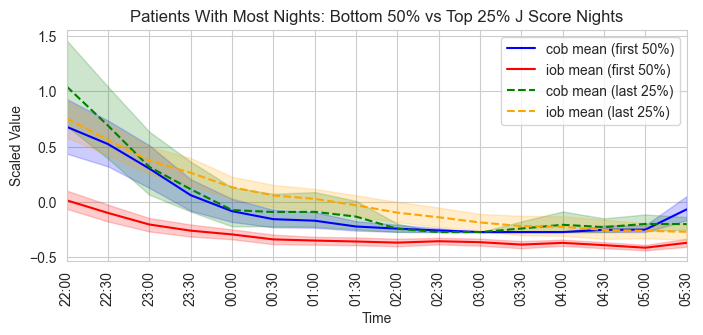

In [66]:
patient_scores = evening_means.loc[top_n].sort_values('score')
top_n_df = df_scaled.loc[top_n][plot_cols].reset_index().copy()

first_50_df, last_25_df = split_patient_score_groups(patient_scores, top_n_df)
title = f'Patients With Most Nights: Bottom 50% vs Top 25% J Score Nights'
filename = 'comparison_bottom50_top_50_patients_most_nights.png'
print(f'Patients with Most Nights: Patients - {len(top_n)}, Nights - {len(patient_scores)}')
plot_top_and_bottom_scoring_nights(first_50_df, last_25_df, title, filename)

In [67]:
test_dtw_distance(top_n_df, first_50_df, last_25_df)

DTW distance (cob mean): 0.980
DTW distance (iob mean): 3.329

Testing differences in means for cob mean...
t-test for cob mean: t(2906.34)=-1.85, p=0.0637
Mann-Whitney U for cob mean: U=2591837.50, p=0.0001

Testing differences in means for iob mean...
t-test for iob mean: t(2196.84)=-20.53, p=0.0000
Mann-Whitney U for iob mean: U=1695255.50, p=0.0000


The DTW distances between the first 50% and the last 25% of nights for patient N is COB=0.285 and IOB=3.592 compared to COB=0.98 and IOB=3.33 for the other four patients. This highlights some similarity and a general characteristic that is appearing for nights with the higher objective function score: the more variability there is in blood glucose overnight, the higher the general levels of insulin. A Mann-Whitney U test shows $p=0.000$ for our COB mean between the lowest objective function score and the highest 25% in this group, indicating a statistically significant difference between the two groups of nights with a stronger U statistic.

Staying consistent with the comparison of the lowest scoring 50% of nights and the highest 25%, we see from the following analysis if there is a relationship between the cluster membership and the objective function score across the whole dataset.

Number of nights in first 50%: 461
Number of nights in last 25%: 231
Patients - 16, Nights - 922
Whole Sample Comparison: Bottom 50% vs Top 25% J Score Nights


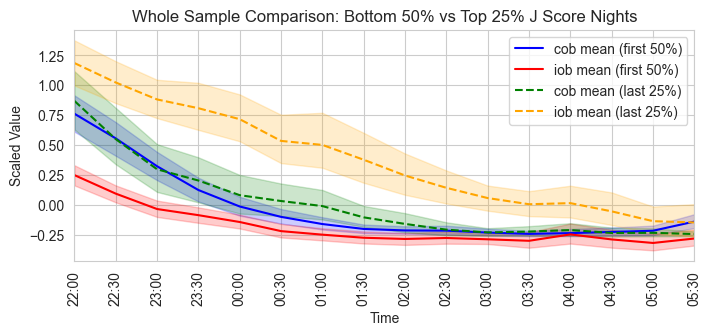

DTW distance (cob mean): 0.493
DTW distance (iob mean): 5.678

Testing differences in means for cob mean...
t-test for cob mean: t(6273.87)=-1.84, p=0.0665
Mann-Whitney U for cob mean: U=13137748.00, p=0.0133

Testing differences in means for iob mean...
t-test for iob mean: t(4736.25)=-23.90, p=0.0000
Mann-Whitney U for iob mean: U=8068864.00, p=0.0000


In [68]:
all_df = df_scaled[plot_cols].reset_index().copy()

first_50_df, last_25_df = split_patient_score_groups(evening_means.sort_values('score'), all_df)
title = f'Whole Sample Comparison: Bottom 50% vs Top 25% J Score Nights'
filename = 'comparison_bottom50_top25_full_sample.png'
print(f'Patients - {len(evening_means.index.get_level_values("id").unique())}, Nights - {len(evening_means)}')
plot_top_and_bottom_scoring_nights(first_50_df, last_25_df, title, filename)
test_dtw_distance(all_df, first_50_df, last_25_df)

The full sample shows an even starker difference between the two groups being statistically compared. The Mann-Whitney U statistics are strong 1.3+e7 (for COB) and 8.0+e6 (for IOB) with p-values of < 0.05 for both.


In [69]:
cluster_summary = df_all.reset_index()[['cluster', 'id', 'night_start_date']].drop_duplicates().groupby('cluster').agg({'night_start_date': 'count'}).rename(columns={'night_start_date': 'nights'}).sort_values(by='nights', ascending=False)
cluster_summary['percentage'] = cluster_summary['nights'] / cluster_summary['nights'].sum() * 100

evening_means.loc[first_50_df.index, 'grouped'] = 'first_50'
evening_means.loc[last_25_df.index, 'grouped'] = 'last_25'
grouped_summary = evening_means.groupby(['cluster', 'grouped']).size().unstack(fill_value=0)
grouped_summary['first_50_percentage'] = grouped_summary['first_50'] / grouped_summary['first_50'].sum() * 100
grouped_summary['last_25_percentage'] = grouped_summary['last_25'] / grouped_summary['last_25'].sum() * 100

column_names={'nights':'Cluster $m$', 'percentage':'\% of Sample $m$', 'first_50':'$J_{\\text{bottom50}}$ $m$', 'last_25': '$J_{\\text{top25}}$ $m$', 'first_50_percentage': '$J_{\\text{bottom50}}$ $m$ \%', 'last_25_percentage': '$J_{\\text{top25}}$ $m$ \%'}
col_order = list(column_names.keys())
grouped_table = grouped_summary.join(cluster_summary[['nights', 'percentage']]).sort_values(by='nights', ascending=False)
grouped_table = grouped_table[col_order].rename(columns=column_names).sort_index()
display(grouped_table)
print(grouped_table.to_latex(
    float_format="%.2f",
    caption="Sample size of nights for $J_{\\text{bottom50}}$ and $J_{\\text{top25}}$ from full sample of $m=922$.",
    label="tab:full_sample_j_score_nights_bottom50_top25",
    bold_rows=True,
    position="h!"
))


,Cluster $m$,\% of Sample $m$,$J_{\text{bottom50}}$ $m$,$J_{\text{top25}}$ $m$,$J_{\text{bottom50}}$ $m$ \%,$J_{\text{top25}}$ $m$ \%
cluster,,,,,,
0,124,13.44902,66,29,14.31670,12.55411
1,106,11.49675,30,50,6.50759,21.64502
2,264,28.63341,146,57,31.67028,24.67532
3,428,46.42082,219,95,47.50542,41.12554


\begin{table}[h!]
\caption{Sample size of nights for $J_{\text{bottom50}}$ and $J_{\text{top25}}$ from full sample of $m=922$.}
\label{tab:full_sample_j_score_nights_bottom50_top25}
\begin{tabular}{lrrrrrr}
\toprule
 & Cluster $m$ & \% of Sample $m$ & $J_{\text{bottom50}}$ $m$ & $J_{\text{top25}}$ $m$ & $J_{\text{bottom50}}$ $m$ \% & $J_{\text{top25}}$ $m$ \% \\
cluster &  &  &  &  &  &  \\
\midrule
\textbf{0} & 124 & 13.45 & 66 & 29 & 14.32 & 12.55 \\
\textbf{1} & 106 & 11.50 & 30 & 50 & 6.51 & 21.65 \\
\textbf{2} & 264 & 28.63 & 146 & 57 & 31.67 & 24.68 \\
\textbf{3} & 428 & 46.42 & 219 & 95 & 47.51 & 41.13 \\
\bottomrule
\end{tabular}
\end{table}



The results show a strong association of high objective function scores with cluster 1, which helps validate the objective function's ability to distinguish between nights and a strong association with the objective function and IOB levels. It is now important to reflect on the objective function components to see if there are any prominent features in this association. The following analysis will look at the relationship between the objective function score and the individual components of the objective function, to see if there are any strong associations that can be drawn.

In [70]:
scaled_weighted_features = obj_func.get_scaled_features()
scaled_weighted_features = scaled_weighted_features.join(clusters, how='left', on=['id', 'night_start_date'])
scaled_weighted_summary = scaled_weighted_features.groupby('cluster').agg({
    'bg_night_mean': 'mean',
    'bg_night_std': 'mean',
    'bg_night_cv': 'mean',
    'l1_excursions': 'mean',
    'l2_excursions': 'mean',
    'mage': 'mean',
})

Mean Scaled Weighted Features by Cluster


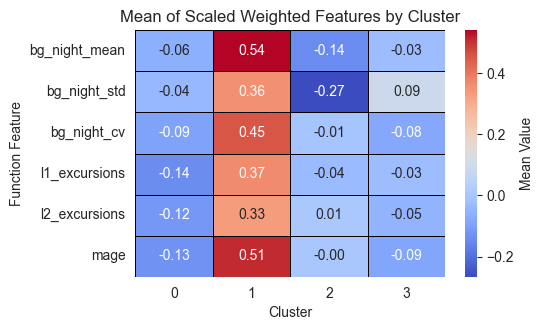

In [71]:
title = 'Mean Scaled Weighted Features by Cluster'
print(title)
fig, ax = plt.subplots(figsize=(5, 3.2))
sns.heatmap(scaled_weighted_summary.T,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            #vmin=-1, vmax=1,
            cbar_kws={'label': 'Mean Value'},
            linewidths=.5,
            linecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Function Feature')
plt.title('Mean of Scaled Weighted Features by Cluster')
plt.savefig(FIGURES_DIR / f'{title.replace(" ", "_").lower()}.png',bbox_inches='tight')
plt.show()

The objective function components provide interpretability behind the score. These are means of the weighted scaled components per night, providing an illustration of how they contribute to the association. The differences in score are striking across all components, though it is clear that these variables are not all independent. For instance, the level of the BG mean would be a good indicator that someone is more prone to hyper or hypo glycaemic events. If someone - due to their unique conditions - is prone to a higher mean BG, they will find it more difficult keeping it within the target L1 hyper threshold given the smaller margin to a global threshold, though it might be that this is an acceptable state according to their clinician and circumstances. Thus, L1 excursions should be interpreted in the context of the mean BG. The same applies to L2 excursions, which are more severe and thus less likely to be acceptable. While the main reflection here is that there L1 excursions could be considered less influential, therefore carrying less weight in the function, this will matter little to the observed outcome, that cluster 1 is associated with the highest objective function scores.

In [72]:
excursions_unscaled = df_features.groupby('cluster').agg({
    'l1_hypo': 'sum',
    'l1_hyper': 'sum',
    'l2_hypo': 'sum',
    'l2_hyper': 'sum',
    'excursion_flag': 'sum',
    'excursion_amplitude': 'sum',
}).assign(excursion_flag_proportion=lambda x: x['excursion_flag'] / x['excursion_flag'].sum(),
          excursion_amplitude_proportion=lambda x: x['excursion_amplitude'] / x['excursion_amplitude'].sum(),)

excursions_scaled = df_scaled.groupby('cluster').agg({
    'l1_hypo': 'sum',
    'l1_hyper': 'sum',
    'l2_hypo': 'sum',
    'l2_hyper': 'sum',
    'excursion_flag': 'sum',
    'excursion_amplitude': 'sum',
}).assign(excursion_flag_proportion=lambda x: x['excursion_flag'] / x['excursion_flag'].sum(),
          excursion_amplitude_proportion=lambda x: x['excursion_amplitude'] / x['excursion_amplitude'].sum(),)

print('Unscaled Excursion Summary:')
display(excursions_unscaled)
print('Scaled Excursion Summary:')
display(excursions_scaled)

Unscaled Excursion Summary:


,l1_hypo,l1_hyper,l2_hypo,l2_hyper,excursion_flag,excursion_amplitude,excursion_flag_proportion,excursion_amplitude_proportion
cluster,,,,,,,,
0,67,271,13,44,468.00000,26591.60805,0.13073,0.12539
1,58,435,15,122,397.00000,30742.92966,0.11089,0.14496
2,296,529,74,108,1117.00000,60800.88614,0.31201,0.28669
3,187,1162,29,220,1598.00000,93941.61685,0.44637,0.44296


Scaled Excursion Summary:


,l1_hypo,l1_hyper,l2_hypo,l2_hyper,excursion_flag,excursion_amplitude,excursion_flag_proportion,excursion_amplitude_proportion
cluster,,,,,,,,
0,-73.68966,-138.15648,-48.86610,-123.89131,-30.62487,-57.73301,-97956074992423.67188,225699955605693.25000
1,-58.72370,432.24042,-0.25418,361.46800,-31.56638,193.78413,-100967562433069.15625,-757574754272604.25000
2,609.89834,-425.73389,386.83436,-185.42146,212.50620,1.37758,679717917150521.50000,-5385458150054.60938
3,-477.48497,131.64995,-337.71408,-52.15523,-150.31495,-137.42869,-480794279725027.75000,537260256816966.56250


The number of excursions against L1 and L2 hyperglycaemia is significantly higher in cluster 1, which is consistent with the association of cluster 1 with the highest objective function scores. What is interesting here however is that this number of excursions beyond arbitrary boundaries does not reflect that of the qualifying amplitude excursions that the MAGE variability metric incorporates. Cluster 1 has only 21.5% of total amplitude excursions of the four clusters, but 32.5% of the sum of amplitudes, meaning these excursions are larger in magnitude but less frequent. This is consistent with the association of cluster 1 to the highest objective function scores, as it indicates that while there are fewer amplitude excursions, they are more pronounced and more disruptive. While the association with high IOB and the cluster is strong, the high scaled values for l1_hyper and l2_hyper components will carry significant weight. These totals have undergone weighting in the objective function which is not represented here.


While focussing on IOB because of the distinct association with the objective function score and how this is unique in cluster 1, this neglects the possibly subtle but important relationship between COB and the objective function score. The following analysis will look at the relationship between COB and the objective function score by cluster, to see if there is any strong association that can be drawn. The first perspective is comparing the DTW distance between the COB mean of the first 50% of nights and the last 25% of nights for each cluster, to see if there is any notable difference.

DTW distance matrix between clusters (COB mean):


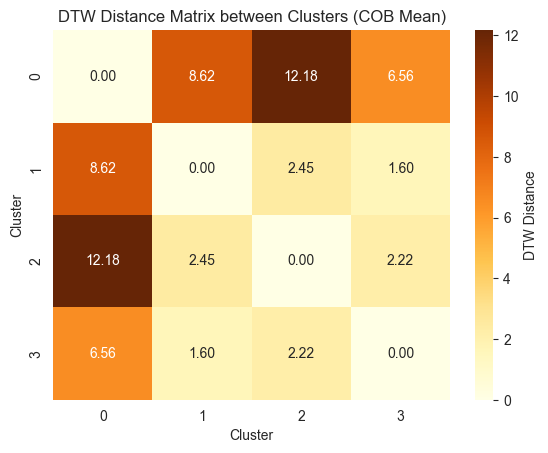

In [73]:
from itertools import combinations
dtw_matrix = pd.DataFrame(index=range(df_scaled['cluster'].nunique()), columns=range(df_scaled['cluster'].nunique()))

# Compute mean COB time series for each cluster
cluster_means = {}
for cluster, cluster_df in df_scaled.reset_index().groupby('cluster'):
    melt_df = transform_time_series_df(cluster_df)
    idx = melt_df.index.drop_duplicates()
    mean_cob = melt_df[melt_df['feature'] == 'cob mean'].loc[idx].reset_index().pivot(index=['id', 'night_start_date'], columns='datetime', values='value').mean(axis=0).values
    cluster_means[cluster] = mean_cob

# Fill DTW distance matrix
for i, j in combinations(cluster_means.keys(), 2):
    dist = dtw(cluster_means[i], cluster_means[j], dist=lambda x, y: abs(x - y))[0]
    dtw_matrix.loc[i, j] = dist
    dtw_matrix.loc[j, i] = dist
for k in cluster_means.keys():
    dtw_matrix.loc[k, k] = 0.0

print("DTW distance matrix between clusters (COB mean):")
sns.heatmap(dtw_matrix.astype(float), annot=True, fmt=".2f", cmap="YlOrBr", cbar_kws={'label': 'DTW Distance'})
plt.title('DTW Distance Matrix between Clusters (COB Mean)')
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.show()


Cluster 0: 0.519
Cluster 1: 0.844
Cluster 2: 2.226